In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math as math

In [2]:
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
AU = UNITS.astronomical_unit
s = UNITS.second
year = UNITS.years

<Unit('year')>

In [3]:
r_0 = (1 * AU).to_base_units()/m
v_0 = 0 * m / s
init = State(x=r_0,
             y=0,
             vx=0,
             vy=-30.33e3)

,values
x,149597870691.0 dimensionless
y,0
vx,0
vy,-30330


In [4]:
r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=((1.06*UNITS.year).to(UNITS.second)))

,values
init,x 149597870691.0 dimensionless y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,33450341.533182003 second


In [5]:
def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x,y,vx,vy = state
    unpack(system)
    
    r = sqrt(x**2 + y**2)
    force = G * m1 * m2 / r**2
    direction = math.atan2(y,x) + pi 
    force = Vector(force * math.cos(direction), force*math.sin(direction) )
    return force/m

In [6]:
universal_gravitation(init, system)

<Quantity([-3.54233769e+22  4.33811252e+06], 'meter * newton')>

In [7]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x,y,vx,vy = state
    unpack(system)    

    force = universal_gravitation(state, system)
    dxdt = Vector(vx,vy)
    dvdt = force / m2
    
    return dxdt, dvdt

In [8]:
slope_func(init, 0, system)
help(run_ode_solver)

Help on function run_ode_solver in module modsim:

run_ode_solver(system, slope_func, **options)
    Computes a numerical solution to a differential equation.
    
    `system` must contain `init` with initial conditions,
    `t_0` with the start time, and `t_end` with the end time.
    
    It can contain any other parameters required by the slope function.
    
    `options` can be any legal options of `scipy.integrate.solve_ivp`
    
    system: System object
    slope_func: function that computes slopes
    
    returns: TimeFrame



In [9]:
def event_func(state, t, system):
    x,y,vx,vy = state
    r = sqrt(x**2 + y**2) * m
    return r - system.r_final

In [10]:
event_func(init, 0, system)

<Quantity(148895991691.0, 'meter')>

In [11]:
ts = linspace(t_0, system.t_end, 500)*s
results, details = run_ode_solver(system, slope_func,vectorized=True, events=event_func, t_eval=ts,method="RK23")
results.index /= 60 * 60 * 25
results.x /= 1e9
results.y /= 1e9
details

,values
sol,None
t_events,[[]]
nfev,137
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


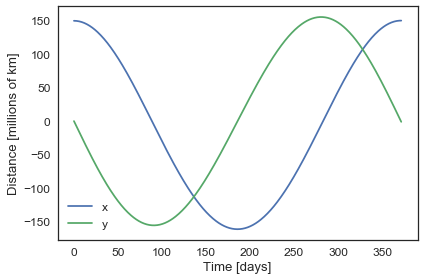

In [12]:

results.x.plot()
results.y.plot()
decorate(ylabel='Distance [millions of km]',
        xlabel='Time [days]')

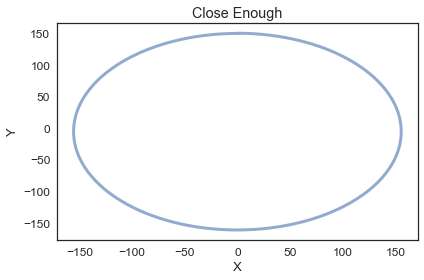

In [13]:
plot(results.y,results.x)
decorate(xlabel='X',
        ylabel='Y',
        title='Close Enough')